**LSA**

### DATA

#### Tiền xử lý dữ liệu

In [17]:
import pandas as pd
import warnings 

warnings.filterwarnings("ignore", category=UserWarning)

df = pd.read_csv("D:\\Introduction to AI\\Project-AI\\lsa-model\\data\\data-1.csv")

# Xóa các cột không cần thiết
df= df.drop(["Unnamed: 0", "Dataset"], axis=1)

# Chuyển về chữ thường
df['Document'] = df['Document'].str.lower()

In [18]:
import re
from underthesea import word_tokenize, sent_tokenize

# Hàm bảo vệ số liệu
def protect_numbers(text):
    """
    Thay thế dấu thập phân '.' bằng '_' để tránh tokenizer cắt tách số.
    Ví dụ: "12.5" → "12_5".
    """
    return re.sub(r'(\d+)\.(\d+)', r'\1_\2', text)

def restore_numbers(text):
    """
    Khôi phục lại định dạng số sau khi đã xử lý tokenizer.
    Ví dụ: "12_5" → "12.5".
    """
    return text.replace('_', '.')

# Áp dụng bảo vệ dữ liệu trước khi tách câu
df['Document_safe'] = df['Document'].apply(protect_numbers)

# Tách câu trước khi xử lý tokenize
df['Documents_sentences'] = df['Document_safe'].apply(lambda x: sent_tokenize(x))

# Khôi phục lại dữ liệu về đúng định dạng
df['Documents_sentences'] = df['Documents_sentences'].apply(
    lambda sents: [restore_numbers(sent) for sent in sents]
)

# Tokenize từng câu bằng Underthesea
df['Documents_sentences_tokenized'] = df['Documents_sentences'].apply(
    lambda sents: [word_tokenize(sent, format="text") for sent in sents]
)

print(df.head())

                                            Document  \
0  đây là một trong những nội dung tại văn bản vừ...   
1  chiều 12/3 , ông vũ hùng triều , trưởng phòng ...   
2  thoạt đầu nhìn vào bức ảnh , nếu không có dấu ...   
3  khoảng 9h30 sáng 5/6 , anh đào nhật tuấn ( 30 ...   
4  liên minh tự do dân sự mỹ ( aclu ) đã nhận đượ...   

                                             Summary  \
0  Các quận , huyện , thị xã tuyên truyền bằng nh...   
1  Cháu bé được phát hiện trong tình trạng chưa c...   
2  Báo tuyết ( Panthera uncia ) được mệnh danh là...   
3  Thấy con chim bị mắc bẫy rơi xuống hồ nước , a...   
4  Loại " huyết thanh nói thật " mà CIA sử dụng đ...   

                                       Document_safe  \
0  đây là một trong những nội dung tại văn bản vừ...   
1  chiều 12/3 , ông vũ hùng triều , trưởng phòng ...   
2  thoạt đầu nhìn vào bức ảnh , nếu không có dấu ...   
3  khoảng 9h30 sáng 5/6 , anh đào nhật tuấn ( 30 ...   
4  liên minh tự do dân sự mỹ ( aclu ) đã nhận 

#### Phân tích thống kê sau tiền xử lý

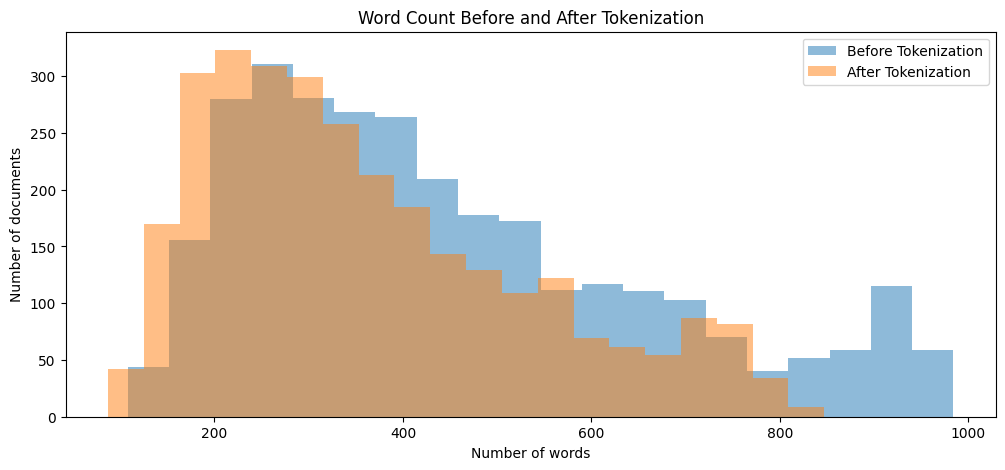

In [19]:
import matplotlib.pyplot as plt

# Số từ trước và sau khi tokenization
df['length_before'] = df['Document'].apply(lambda x: len(x.split()))
df['length_after'] = df['Documents_sentences_tokenized'].apply(
    lambda sents: sum(len(sent.split()) for sent in sents)
)

# Biểu đồ trước và sau khi tokenziation
plt.figure(figsize=(12,5))
plt.hist(df['length_before'], bins=20, alpha=0.5, label='Before Tokenization')
plt.hist(df['length_after'], bins=20, alpha=0.5, label='After Tokenization')
plt.xlabel('Number of words')
plt.ylabel('Number of documents')
plt.title('Word Count Before and After Tokenization')
plt.legend()
plt.show()

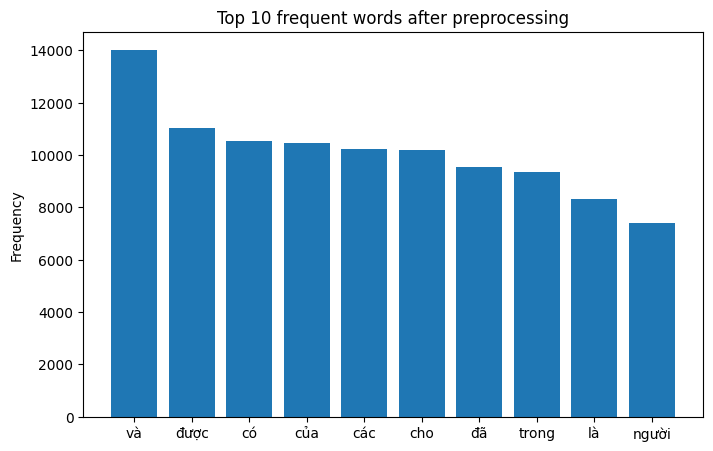

In [20]:
from collections import Counter

# Thống kê tần suất từ xuất hiện nhiều nhất
all_words = [word 
             for doc in df['Documents_sentences_tokenized'] 
             for sent in doc 
             for word in sent.split()
]

# Loại bỏ dấu câu
punctuations = {'.', '!', '?', ',', ':', ';', '(', ')', '-', '"', "'"}
all_words = [w for w in all_words if w not in punctuations]

# Top 10 từ xuất hiện nhiều nhất
most_common = Counter(all_words).most_common(10)
words, counts = zip(*most_common)

plt.figure(figsize=(8,5))
plt.bar(words, counts)
plt.title('Top 10 frequent words after preprocessing')
plt.ylabel('Frequency')
plt.show()

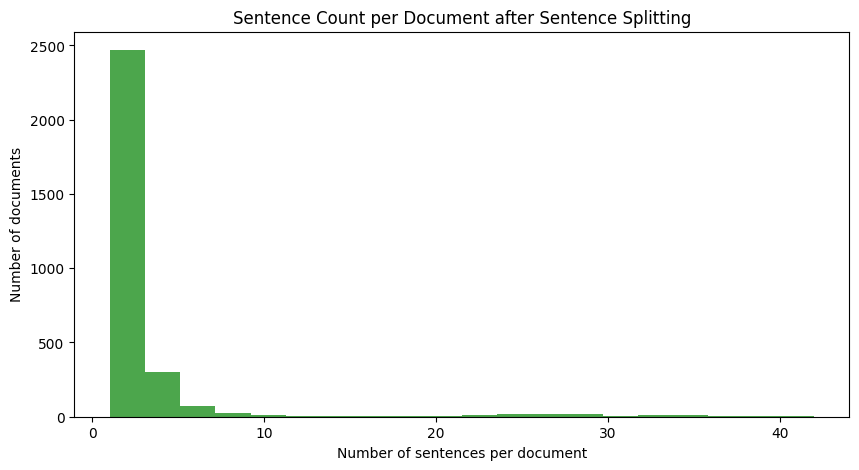

In [21]:
# Số câu trong mỗi văn bản
df['num_sentences'] = df['Documents_sentences_tokenized'].apply(len)

plt.figure(figsize=(10,5))
plt.hist(df['num_sentences'], bins=20, alpha=0.7, color='green')
plt.xlabel('Number of sentences per document')
plt.ylabel('Number of documents')
plt.title('Sentence Count per Document after Sentence Splitting')
plt.show()

#### Biểu diễn câu bằng TF-IDF

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Gộp tất cả câu thành một danh sách
all_sentences = [sentence for doc in df['Documents_sentences_tokenized'] for sentence in doc]

# Khởi tạo TF-IDF
vectorizer = TfidfVectorizer(
    max_features=5000,   # số từ tối đa để giảm ma trận quá lớn
    stop_words=None      # đã xóa stopwords trước đó
)

# Biến tất cả câu thành ma trận TF-IDF
tfidf_matrix = vectorizer.fit_transform(all_sentences)
print(tfidf_matrix.shape)
vectorizer.get_feature_names_out()

(9490, 5000)


array(['000', '01', '02', ..., 'ứng_dụng', 'ứng_phó', 'ứng_xử'],
      shape=(5000,), dtype=object)

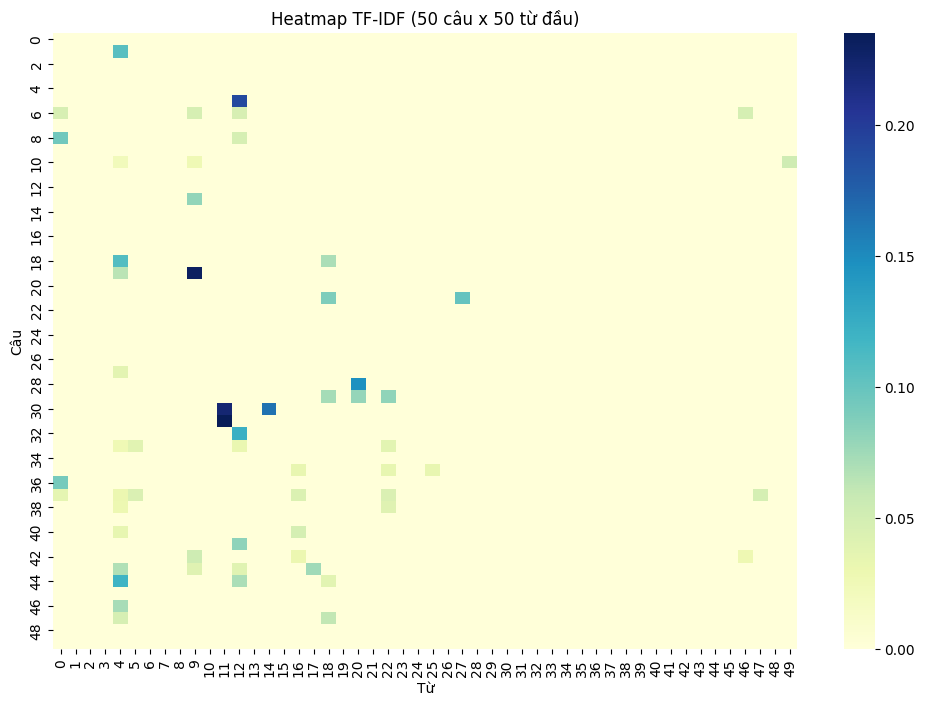

In [23]:
import seaborn as sns

# Biểu diễn vector cho tất cả các câu
tfidf_sample = tfidf_matrix[:50,:50].toarray()

plt.figure(figsize=(12,8))
sns.heatmap(tfidf_sample, cmap="YlGnBu")
plt.title("Heatmap TF-IDF (50 câu x 50 từ đầu)")
plt.xlabel("Từ")
plt.ylabel("Câu")
plt.show()

#### Áp dụng LSA (SVD)

In [24]:
from sklearn.decomposition import TruncatedSVD

k = 5 # số chủ đề rút trích

svd = TruncatedSVD(n_components=k, random_state=42)

lsa_matrix = svd.fit_transform(tfidf_matrix)
print(lsa_matrix.shape)

# In ra top từ đại diện mỗi chủ đề
terms = vectorizer.get_feature_names_out()
n_top_words = 10  # số từ quan trọng muốn hiển thị

for topic_idx, topic in enumerate(svd.components_):
    top_terms = sorted(zip(terms, topic), key=lambda x: abs(x[1]), reverse=True)[:n_top_words]
    top_terms = [(word, round(float(weight), 3)) for word, weight in top_terms]
    print(f"Top words for topic {topic_idx}: {top_terms}")
    print()

(9490, 5)
Top words for topic 0: [('và', 0.197), ('được', 0.17), ('các', 0.165), ('có', 0.162), ('của', 0.161), ('cho', 0.159), ('đã', 0.155), ('trong', 0.147), ('người', 0.143), ('bệnh_viện', 0.138)]

Top words for topic 1: [('bệnh_viện', 0.279), ('bé', 0.191), ('những', -0.168), ('cháu', 0.164), ('loài', -0.153), ('chị', 0.143), ('cấp_cứu', 0.137), ('nghiên_cứu', -0.137), ('huyện', 0.135), ('các', -0.133)]

Top words for topic 2: [('con', 0.364), ('cá', 0.267), ('bệnh_viện', -0.233), ('bệnh_nhân', -0.222), ('bác_sĩ', -0.178), ('các', -0.175), ('y_tế', -0.17), ('anh', 0.16), ('bệnh', -0.137), ('bé', 0.124)]

Top words for topic 3: [('bé', 0.282), ('tôi', 0.275), ('cá', -0.215), ('tỉnh', -0.154), ('cháu', 0.153), ('huyện', -0.151), ('không', 0.141), ('ông', -0.128), ('bác_sĩ', 0.128), ('xã', -0.127)]

Top words for topic 4: [('cá', 0.354), ('bệnh_nhân', 0.324), ('bé', -0.254), ('bệnh_viện', 0.234), ('cháu', -0.205), ('bác_sĩ', 0.192), ('máu', 0.178), ('anh', 0.175), ('chó', -0.157), ('

#### Tính score của câu và sinh summary

In [25]:
import numpy as np

# Score câu = tổng giá trị tuyệt đối vector LSA
sentence_scores = np.sum(np.abs(lsa_matrix), axis=1)

# Lấy 10 câu quan trọng nhất
top_indices = np.argsort(sentence_scores)[-10:][::-1]  # sắp xếp giảm dần
for i in top_indices:
    print(all_sentences[i], sentence_scores[i])
    print()

video : con cá_quý được anh sử_nhốt trong khoang thuyềnrạng sáng nay , anh đậu văn_sử ( 24 tuổi , trú thị_xã cửa_lò , nghệ_an ) cùng vợ chèo thuyền thả lưới trên sông cấm_đoạn qua thị_xã cửa_lò thì phát_hiện con cá lớn dính lưới . đưa cá lên thuyền , anh sử ngạc_nhiên vì giống loài cá_sủ vàng quý_hiếm . thân cá có màu vàng óng ánh dài gần 1 m , phần bụng màu trắng , vây đỏ . cá nặng 8,1 kg . ông võ_minh vỹ , chủ_tịch ubnd phường nghi_tân , cho_hay đã trực_tiếp tới xem con cá và thấy " đúng là giống cá sủ vàng , tuy_nhiên chưa_thể khẳng_định chính_xác " . con cá mà vợ_chồng ảnh sử vừa bắt được . hay tin anh vợ_chồng ngư_dân bắt được cá_quý , cả trăm người_dân địa_phương đã kéo tới xem ; một_số thương_lái trả_giá_cả chục triệu đồng để mua con cá nhưng gia_chủ chưa đồng_ý . cá sủ vàng phân_bố chủ_yếu ở vùng_biển ấn_độ , việt_nam , indonesia , sri lanka , trung_quốc và có giá_trị kinh_tế rất cao . mùa sinh_sản vào tháng 1 - 4 và 9-10_âm_lịch , loài cá này thường vào các vùng cửa_sông nước_

In [26]:
# Sinh summary cho từng văn bản
summary_ratio = 0.3  # 30% số câu
summaries = []

for doc_idx, sentences in enumerate(df['Documents_sentences_tokenized']):
    # Lấy score của các câu thuộc văn bản này
    start_idx = sum(df['Documents_sentences_tokenized'].iloc[:doc_idx].apply(len))
    end_idx = start_idx + len(sentences)
    scores = sentence_scores[start_idx:end_idx]

    # Số câu muốn chọn
    k = max(1, int(len(sentences) * summary_ratio))

    # Lấy indices các câu quan trọng nhất
    top_sentence_indices = np.argsort(scores)[-k:]

    # Sắp xếp theo thứ tự xuất hiện trong văn bản
    top_sentence_indices = sorted(top_sentence_indices)

    # Tạo summary
    summary = ' '.join([sentences[i] for i in top_sentence_indices])
    summaries.append(summary)

# Thêm vào dataframe
df['Summary_LSA'] = summaries

# Kiểm tra kết quả
for i in range(10):
    print("Original Document:\n", df['Document'].iloc[i][:300], "...\n")
    print("Summary:\n", df['Summary_LSA'].iloc[i], "\n")
    print("="*80)

Original Document:
 đây là một trong những nội dung tại văn bản vừa được ubnd tp hà nội ban hành về việc tăng cường công tác quản lý nuôi , giết mổ , kinh doanh và sử dụng thịt chó , mèo trên địa bàn .theo đó , các sở , ngành trên địa bàn phải vào cuộc ngay để hướng tới thay đổi thói quen của người dân khi dùng chó , m ...

Summary:
 hoàn_toàn có_thể thay_đổi một thói_quen xấu nếu được truyền_thông tốt , mà việc bỏ ăn_tiết_canh là một ví_dụ . trước_đây các hàng_quán " lòng lợn , tiết_canh " mọc khắp_nơi bởi đây là món khoái_khẩu của dân nhậu . nhưng khi báo_chí đưa tin nhiều về các ca nhiễm_khuẩn cầu lợn gây tử_vong với những triệu_chứng khủng_khiếp , gần như món ăn này bị tẩy_chay , hiện rất ít người dùng món ăn này " - vị này nói . trong khi đó , không_chỉ những bạn trẻ nuôi chó cảnh làm thú_cưng phản_đối việc xem chó là một loại thực_phẩm , mà ngay cả những người từng xem thịt chó là món " khoái_khẩu " cũng ủng_hộ việc bỏ ăn thịt chó . dù từng ăn thịt chó , anh nguyễn_văn_thuận , mộ

In [27]:
# In văn bản
with open("D:\\Introduction to AI\\Project-AI\\lsa-model\\data\\train_data_summaries.txt", "w", encoding="utf-8") as f:
    for i in range(min(1000, len(df))):
        f.write(f"Document {i+1}:\n")
        f.write("Original: " + df['Document'].iloc[i] + "\n")
        f.write("Summary: " + df['Summary_LSA'].iloc[i] + "\n")
        f.write("="*80 + "\n")

#### Bert Score Evalution

In [28]:
'''
from bert_score import score

# Lấy danh sách tóm tắt của mô hình và tóm tắt gốc
candidates = df['Summary_LSA'].tolist()
references = df['Summary'].tolist()

batch_size = 8

precision_list, recall_list, f1_list = [], [], []

# Duyệt từng batch để tính BertScore
for i in range(0, len(candidates), batch_size):
    cand_batch = candidates[i:i+batch_size]
    ref_batch = references[i:i+batch_size]
    
    # Tính BertScore cho batch hiện tại
    P, R, F1 = score(cand_batch, ref_batch, lang='en', rescale_with_baseline=True)
    
    # Chuyển tensor sang list và lưu kết quả
    precision_list.extend(P.tolist())
    recall_list.extend(R.tolist())
    f1_list.extend(F1.tolist())

df_bert = pd.DataFrame({
    'precision': precision_list,
    'recall': recall_list,
    'f1': f1_list
})

print(df_bert.head())

mean_precision = df_bert['precision'].mean()
mean_recall = df_bert['recall'].mean()
mean_f1 = df_bert['f1'].mean()

print("Avg Precision:", mean_precision)
print("Avg Recall:", mean_recall)
print("Avg F1:", mean_f1)
'''

print("Hello")

Hello


In [29]:
'''
# Ghi kết quả ra file
with open("D:\\Introduction to AI\\Project-AI\\lsa-model\\data\\train_berts_scores.txt", "w", encoding="utf-8") as f:
    f.write("===== BERTS Scores (documents) =====\n")
    f.write(df_bert.round(3).to_string())

    f.write("\n\n===== Average Precision =====\n")
    f.write(str(round(mean_precision, 3)))

    f.write("\n\n===== Average Recall =====\n")
    f.write(str(round(mean_recall, 3)))

    f.write("\n\n===== Average F1 =====\n")
    f.write(str(round(mean_f1, 3)))
'''

print("Hello")

Hello


#### Rouge Score

In [30]:
from rouge import Rouge
import pandas as pd

rouge = Rouge()
scores_list = []

for i in range(len(df)):
    reference = df['Summary'].iloc[i]          # summary chuẩn
    generated = df['Summary_LSA'].iloc[i]     # summary LSA
    scores = rouge.get_scores(generated, reference)[0]
    scores_list.append(scores)

# Tạo dataframe
df_rouge = pd.DataFrame(scores_list)

# Tách các thành phần rouge-1, rouge-2, rouge-l
rouge_1 = df_rouge['rouge-1'].apply(pd.Series)
rouge_2 = df_rouge['rouge-2'].apply(pd.Series)
rouge_l = df_rouge['rouge-l'].apply(pd.Series)

# Tính trung bình
avg_rouge_1 = rouge_1.mean()
avg_rouge_2 = rouge_2.mean()
avg_rouge_l = rouge_l.mean()

# In ra console
print("Average ROUGE-1:\n", round(avg_rouge_1, 3))
print("Average ROUGE-2:\n", round(avg_rouge_2, 3))
print("Average ROUGE-L:\n", round(avg_rouge_l, 3))

Average ROUGE-1:
 r    0.386
p    0.102
f    0.155
dtype: float64
Average ROUGE-2:
 r    0.117
p    0.021
f    0.035
dtype: float64
Average ROUGE-L:
 r    0.344
p    0.090
f    0.138
dtype: float64


In [31]:
# Ghi kết quả ra file
with open("D:\\Introduction to AI\\Project-AI\\lsa-model\\data\\train_rouge_scores.txt", "w", encoding="utf-8") as f:
    f.write("===== ROUGE Scores (documents) =====\n")
    f.write(df_rouge.map(
        lambda x: {k: round(v, 3) for k, v in x.items()}
    ).to_string())

    f.write("\n\n===== Average ROUGE-1 =====\n")
    f.write(avg_rouge_1.round(3).to_string())

    f.write("\n\n===== Average ROUGE-2 =====\n")
    f.write(avg_rouge_2.round(3).to_string())

    f.write("\n\n===== Average ROUGE-L =====\n")
    f.write(avg_rouge_l.round(3).to_string())

#### Cosine Similarity

In [32]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_scores = []

for i in range(len(df)):
    documents = [df['Summary_LSA'].iloc[i], df['Summary'].iloc[i]]  # LSA summary và summary gốc
    vect = TfidfVectorizer().fit_transform(documents)
    score = cosine_similarity(vect[0:1], vect[1:2])[0][0]  # cosine similarity giữa 2 vector
    cosine_scores.append(score)

df['cosine_score'] = cosine_scores

print("Average Cosine similarity:", round(np.mean(cosine_scores), 3))

Average Cosine similarity: 0.174


In [33]:
# Ghi kết quả cosine similarity ra file
with open("D:\\Introduction to AI\\Project-AI\\lsa-model\\data\\train_cosine_scores.txt", "w", encoding="utf-8") as f:
    f.write("===== Cosine Similarity Scores (per document) =====\n\n")
    for i in range(len(df)):
        f.write(f"Document {i+1}:\n")
        f.write("Cosine similarity: " + str(round(df['cosine_score'].iloc[i], 3)) + "\n")
        f.write("="*24 + "\n")
    
    f.write("\nAverage Cosine similarity: " + str(round(df['cosine_score'].mean(), 3)) + "\n")

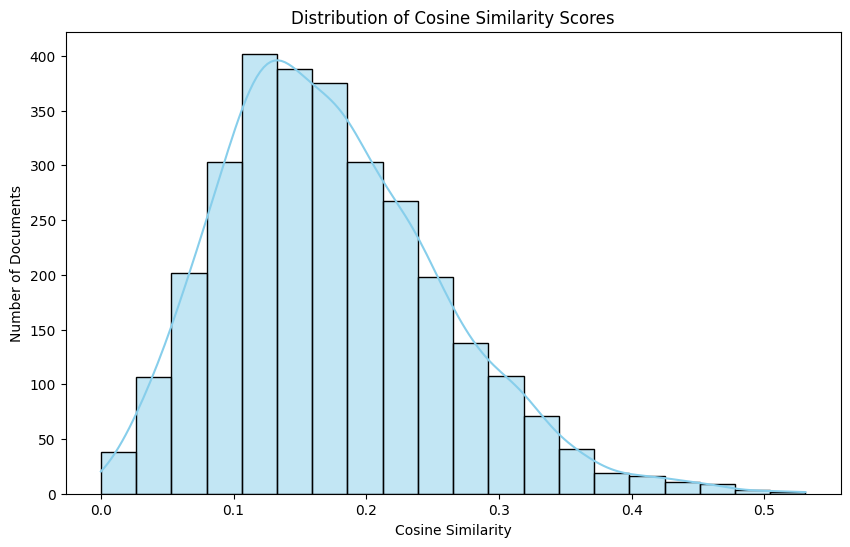

In [34]:
plt.figure(figsize=(10,6))
sns.histplot(df['cosine_score'], bins=20, kde=True, color='skyblue')
plt.title("Distribution of Cosine Similarity Scores")
plt.xlabel("Cosine Similarity")
plt.ylabel("Number of Documents")
plt.show()

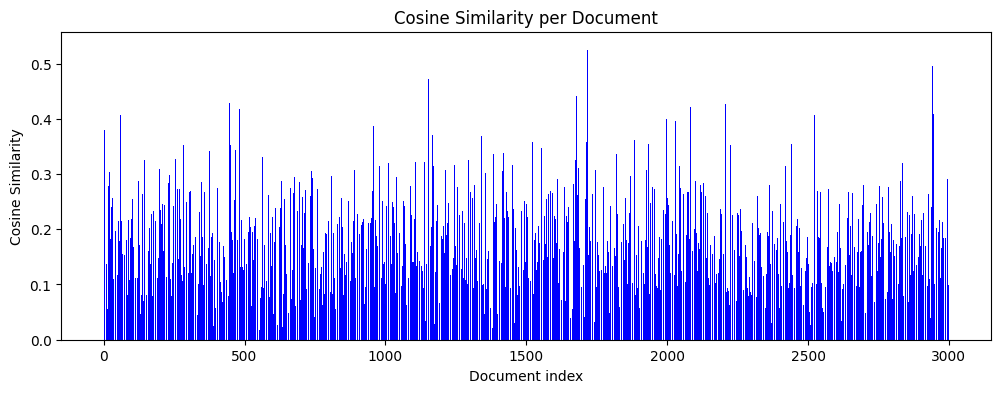

In [35]:
plt.figure(figsize=(12,4))
plt.bar(range(len(df)), df['cosine_score'], color='blue')
plt.xlabel('Document index')
plt.ylabel('Cosine Similarity')
plt.title('Cosine Similarity per Document')
plt.show()


### TEST

In [36]:
df = pd.read_csv("D:\\Introduction to AI\\Project-AI\\lsa-model\\data\\test.csv")

df['text'] = df['text'].str.lower()

def protect_numbers(text):
    return re.sub(r'(\d+)\.(\d+)', r'\1_\2', text)

def restore_numbers(text):
    return text.replace('_', '.')

df['texts_safe'] = df['text'].apply(protect_numbers)

df['texts_sentences'] = df['texts_safe'].apply(lambda x: sent_tokenize(x))

df['texts_sentences'] = df['texts_sentences'].apply(
    lambda sents: [restore_numbers(sent) for sent in sents]
)

df['texts_sentences_tokenized'] = df['texts_sentences'].apply(
    lambda sents: [word_tokenize(sent, format="text") for sent in sents]
)

In [37]:
all_sentences = [sentence for doc in df['texts_sentences_tokenized'] for sentence in doc]

vectorizer = TfidfVectorizer(
    max_features=5000, 
    stop_words=None    
)

tfidf_matrix = vectorizer.fit_transform(all_sentences)

k = 5

svd = TruncatedSVD(n_components=k, random_state=42)

lsa_matrix = svd.fit_transform(tfidf_matrix)

sentence_scores = np.sum(np.abs(lsa_matrix), axis=1)

In [38]:
summary_ratio = 0.3 

summaries = []

for doc_idx, sentences in enumerate(df['texts_sentences_tokenized']):
    start_idx = sum(df['texts_sentences_tokenized'].iloc[:doc_idx].apply(len))
    end_idx = start_idx + len(sentences)
    scores = sentence_scores[start_idx:end_idx]

    k = max(1, int(len(sentences) * summary_ratio))

    top_sentence_indices = np.argsort(scores)[-k:]

    top_sentence_indices = sorted(top_sentence_indices)

    summary = ' '.join([sentences[i] for i in top_sentence_indices])
    summaries.append(summary)

df['Summary_LSA'] = summaries

In [39]:
for i in range(10):
    print("Original Document:\n", df['text'].iloc[i][:300], "...\n")
    print("Summary:\n", df['Summary_LSA'].iloc[i], "\n")
    print("="*80)

Original Document:
 
sau bài thi ngắn năm mươi phút và bốn mươi câu hỏi trắc nghiệm, phần lớn họ, nếu không chọn ngành khoa học xã hội ở đại học, sẽ tạm dừng “mối duyên” với lịch sử trong nhiều năm về sau này.
khi hàng trăm nghìn cái đầu trẻ chăm chú cúi xuống một bài thi lịch sử, tôi nhớ tới giáo sư phan huy lê, người ...

Summary:
 trong bốn_mươi câu trắc_nghiệm lịch_sử sáng nay , sẽ còn thiếu rất nhiều sự_kiện và sự_thật lịch_sử quan_trọng của việt_nam , mà ngành giáo_dục vẫn còn chưa thống_nhất được với ngành lịch_sử , với những nhà_nghiên_cứu trăn_trở như phan_huy_lê , rằng chúng có nên được đưa vào và sẽ được đưa vào sách_giáo_khoa như_thế_nào . lần đầu_tiên tôi nhận ra sự thiếu_hụt trong kiến_thức lịch_sử của mình , là khi đã trở_thành sinh_viên năm thứ ba của trường báo . đó là lần đầu_tiên tôi được đọc cuốn sách về phong_trào nhân_văn giai_phẩm . đó là lần đầu_tiên tôi biết về người đồng_hương nguyễn_hữu đang - nhân_vật được cụ hồ tin_tưởng giao_trọng_trách dựng lễ_đài độc_lập

In [40]:
with open("D:\\Introduction to AI\\Project-AI\\lsa-model\\data\\test_data_summaries.txt", "w", encoding="utf-8") as f:
    for i in range(len(df)):
        f.write(f"Document {i+1}:\n")
        f.write("Original: " + df['text'].iloc[i] + "\n")
        f.write("Summary: " + df['Summary_LSA'].iloc[i] + "\n")
        f.write("="*80 + "\n")

In [41]:
from bert_score import score

candidates = df['Summary_LSA'].tolist()
references = df['summary'].tolist()

batch_size = 8

precision_list, recall_list, f1_list = [], [], []

for i in range(0, len(candidates), batch_size):
    cand_batch = candidates[i:i+batch_size]
    ref_batch = references[i:i+batch_size]
    
    P, R, F1 = score(cand_batch, ref_batch, lang='en', rescale_with_baseline=True, model_type='bert-base-uncased')
    
    precision_list.extend(P.tolist())
    recall_list.extend(R.tolist())
    f1_list.extend(F1.tolist())

df_bert = pd.DataFrame({
    'precision': precision_list,
    'recall': recall_list,
    'f1': f1_list
})

mean_precision = df_bert['precision'].mean()
mean_recall = df_bert['recall'].mean()
mean_f1 = df_bert['f1'].mean()

print("Avg Precision:", round(mean_precision, 3))
print("Avg Recall:", round(mean_recall, 3))
print("Avg F1:", round(mean_f1, 3))

Avg Precision: 0.666
Avg Recall: 0.729
Avg F1: 0.697


In [42]:
# Ghi kết quả ra file
with open("D:\\Introduction to AI\\Project-AI\\lsa-model\\data\\test_berts_scores.txt", "w", encoding="utf-8") as f:
    f.write("===== BERTS Scores (documents) =====\n")
    f.write(df_bert.round(3).to_string())

    f.write("\n\n===== Average Precision =====\n")
    f.write(str(round(mean_precision, 3)))

    f.write("\n\n===== Average Recall =====\n")
    f.write(str(round(mean_recall, 3)))

    f.write("\n\n===== Average F1 =====\n")
    f.write(str(round(mean_f1, 3)))

In [43]:
rouge = Rouge()
scores_list = []

for i in range(len(df)):
    reference = df['summary'].iloc[i]        
    generated = df['Summary_LSA'].iloc[i]     
    scores = rouge.get_scores(generated, reference)[0]
    scores_list.append(scores)

df_rouge = pd.DataFrame(scores_list)

rouge_1 = df_rouge['rouge-1'].apply(pd.Series)
rouge_2 = df_rouge['rouge-2'].apply(pd.Series)
rouge_l = df_rouge['rouge-l'].apply(pd.Series)

avg_rouge_1 = rouge_1.mean()
avg_rouge_2 = rouge_2.mean()
avg_rouge_l = rouge_l.mean()

print("Average ROUGE-1:\n", round(avg_rouge_1, 3))
print("Average ROUGE-2:\n", round(avg_rouge_2, 3))
print("Average ROUGE-L:\n", round(avg_rouge_l, 3))

Average ROUGE-1:
 r    0.314
p    0.388
f    0.346
dtype: float64
Average ROUGE-2:
 r    0.161
p    0.175
f    0.167
dtype: float64
Average ROUGE-L:
 r    0.304
p    0.375
f    0.334
dtype: float64


In [44]:
with open("D:\\Introduction to AI\\Project-AI\\lsa-model\\data\\test_rouge_scores.txt", "w", encoding="utf-8") as f:
    f.write("===== ROUGE Scores (documents) =====\n")
    f.write(df_rouge.map(
        lambda x: {k: round(v, 3) for k, v in x.items()}
    ).to_string())

    f.write("\n\n===== Average ROUGE-1 =====\n")
    f.write(avg_rouge_1.round(3).to_string())

    f.write("\n\n===== Average ROUGE-2 =====\n")
    f.write(avg_rouge_2.round(3).to_string())

    f.write("\n\n===== Average ROUGE-L =====\n")
    f.write(avg_rouge_l.round(3).to_string())

In [45]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_scores = []

for i in range(len(df)):
    texts = [df['Summary_LSA'].iloc[i], df['summary'].iloc[i]]  # LSA summary và summary gốc
    vect = TfidfVectorizer().fit_transform(texts)
    score = cosine_similarity(vect[0:1], vect[1:2])[0][0]  # cosine similarity giữa 2 vector
    cosine_scores.append(score)

df['cosine_score'] = cosine_scores

print("Average Cosine similarity:", round(np.mean(cosine_scores), 3))

Average Cosine similarity: 0.483


In [46]:
with open("D:\\Introduction to AI\\Project-AI\\lsa-model\\data\\test_cosine_scores.txt", "w", encoding="utf-8") as f:
    f.write("===== Cosine Similarity Scores (per document) =====\n\n")
    for i in range(len(df)):
        f.write(f"Document {i+1}:\n")
        f.write("Cosine similarity: " + str(round(df['cosine_score'].iloc[i], 3)) + "\n")
        f.write("="*24 + "\n")
    
    f.write("\nAverage Cosine similarity: " + str(round(df['cosine_score'].mean(), 3)) + "\n")

### SUMMARY TEST

In [47]:
def summarize_LSA(text, summary_ratio=0.5, max_features=5000, n_components=3):
    text = text.lower()
    
    def protect_numbers(t):
        return re.sub(r'(\d+)\.(\d+)', r'\1_\2', t)

    def restore_numbers(t):
        return t.replace('_', '.')

    text_safe = protect_numbers(text)
    sentences = sent_tokenize(text_safe)
    sentences = [restore_numbers(s) for s in sentences]
    sentences_tokenized = [word_tokenize(s, format="text") for s in sentences]

    vectorizer = TfidfVectorizer(max_features=max_features)
    tfidf_matrix = vectorizer.fit_transform(sentences_tokenized)

    svd = TruncatedSVD(n_components=n_components, random_state=42)
    lsa_matrix = svd.fit_transform(tfidf_matrix)

    scores = np.sum(np.abs(lsa_matrix), axis=1) * np.log1p([len(s) for s in sentences])

    k = max(3, int(len(sentences) * summary_ratio))

    top_idx = np.argsort(scores)[-k:]
    top_idx = sorted(top_idx) 

    summary = " ".join(sentences[i] for i in top_idx)

    return summary

In [48]:
document = "Người đầu tiên xứng với danh xưng hảo hán không ai khác chính la Võ Tòng. Cả đời Võ Tòng hành hiệp trượng nghĩa, thích bênh vực kẻ yếu, hoàn toàn giống với một người anh hùng. Hơn nữa Võ Tòng còn là một người yêu hận phân minh, không tàn sát người vô tội, đây là điểm rất quan trọng. Lấy chuyện Võ Tòng báo thù cho Võ Đại Lang làm ví dụ, Võ Tòng chỉ giết đúng hai kẻ liên quan trực tiếp là Phan Kim Liên và Tây Môn Khánh, Võ Tòng không hề ra tay với Vương bà dù bà ta cũng là người góp phần không nhỏ, đối với những người đi hóng chuyện, Võ Tòng cũng không ra tay thảo phạt hàng loạt, làm người rất có chừng mực, cho thấy bản chất đúng đắn của một anh hùng hảo hán. Đứng ở góc độ hiện tại, nhiều người có thể cảm thấy cách cư xử của Võ Tòng là điều hết sức bình thường, bởi lẽ chuyện này quả thực chẳng liên quan tới những người khác, nhưng đây lại chỉ là tư duy của người hiện đại chúng ta, trong Thủy Hử, không thiếu gì hảo hán chẳng cần biết vô tội hay không, chỉ cần động thủ là phải đánh cho tới bến, cho sảng khoái thì thôi. Nếu đổi lại là Lý Quỳ, có lẽ người bị giết sẽ nhiều hơn, chỉ cần là những người biết chuyện của Võ Đại Lang mà không chịu lên tiếng hay làm gì, e là có lẽ đều sẽ bị giết… Nhưng Võ Tòng thì khác, sau khi biết đầu đuôi câu chuyện, Võ Tòng chỉ oan có đầu nợ có chủ, chỉ nhắm vào đương sự, không lạm dụng vũ lực, đây mới chính là anh hùng hảo hán. Thủy Hử 108 anh hùng, chỉ 4 người thực sự là hảo hán gồm những ai."
summary = summarize_LSA(document)

print("===== ORIGINAL DOCUMENT =====\n")
print(document + "\n\n")
print("===== SUMMARY (LSA) =====\n")
print(summary)

===== ORIGINAL DOCUMENT =====

Người đầu tiên xứng với danh xưng hảo hán không ai khác chính la Võ Tòng. Cả đời Võ Tòng hành hiệp trượng nghĩa, thích bênh vực kẻ yếu, hoàn toàn giống với một người anh hùng. Hơn nữa Võ Tòng còn là một người yêu hận phân minh, không tàn sát người vô tội, đây là điểm rất quan trọng. Lấy chuyện Võ Tòng báo thù cho Võ Đại Lang làm ví dụ, Võ Tòng chỉ giết đúng hai kẻ liên quan trực tiếp là Phan Kim Liên và Tây Môn Khánh, Võ Tòng không hề ra tay với Vương bà dù bà ta cũng là người góp phần không nhỏ, đối với những người đi hóng chuyện, Võ Tòng cũng không ra tay thảo phạt hàng loạt, làm người rất có chừng mực, cho thấy bản chất đúng đắn của một anh hùng hảo hán. Đứng ở góc độ hiện tại, nhiều người có thể cảm thấy cách cư xử của Võ Tòng là điều hết sức bình thường, bởi lẽ chuyện này quả thực chẳng liên quan tới những người khác, nhưng đây lại chỉ là tư duy của người hiện đại chúng ta, trong Thủy Hử, không thiếu gì hảo hán chẳng cần biết vô tội hay không, chỉ cầ

In [49]:
document = "Trong những năm gần đây, tình trạng hạn mặn tại Đồng bằng sông Cửu Long diễn biến ngày càng phức tạp và khó dự đoán hơn. Theo các chuyên gia khí tượng, nguyên nhân không chỉ đến từ việc biến đổi khí hậu toàn cầu làm nhiệt độ tăng, lượng mưa giảm mà còn do những thay đổi trong hoạt động điều tiết nguồn nước ở thượng nguồn sông Mekong. Việc xây dựng hàng loạt đập thuỷ điện khiến lưu lượng nước đổ về hạ lưu giảm mạnh vào mùa khô, tạo điều kiện cho nước biển lấn sâu hàng chục kilômét vào các con sông nội địa. Điều này gây ảnh hưởng nghiêm trọng đến sản xuất nông nghiệp, đặc biệt là việc trồng lúa – ngành kinh tế chủ lực của khu vực. Nhiều hộ dân buộc phải bỏ vụ hoặc chuyển sang trồng các loại cây chịu mặn, nhưng hiệu quả kinh tế chưa cao. Không chỉ nông nghiệp, sinh hoạt hàng ngày của người dân cũng gặp nhiều khó khăn do thiếu nước ngọt. Chính quyền địa phương đã triển khai nhiều giải pháp như xây dựng cống ngăn mặn, trữ nước bằng hồ chứa hoặc khuyến khích áp dụng mô hình canh tác thông minh thích ứng biến đổi khí hậu. Tuy nhiên, theo các nhà nghiên cứu, những giải pháp này chỉ mang tính tạm thời. Về lâu dài, cần có sự phối hợp chặt chẽ giữa các quốc gia trong lưu vực Mekong nhằm quản lý, chia sẻ nguồn nước một cách bền vững và công bằng hơn."
summary = summarize_LSA(document)

print("===== ORIGINAL DOCUMENT =====\n")
print(document + "\n\n")
print("===== SUMMARY (LSA) =====\n")
print(summary)

===== ORIGINAL DOCUMENT =====

Trong những năm gần đây, tình trạng hạn mặn tại Đồng bằng sông Cửu Long diễn biến ngày càng phức tạp và khó dự đoán hơn. Theo các chuyên gia khí tượng, nguyên nhân không chỉ đến từ việc biến đổi khí hậu toàn cầu làm nhiệt độ tăng, lượng mưa giảm mà còn do những thay đổi trong hoạt động điều tiết nguồn nước ở thượng nguồn sông Mekong. Việc xây dựng hàng loạt đập thuỷ điện khiến lưu lượng nước đổ về hạ lưu giảm mạnh vào mùa khô, tạo điều kiện cho nước biển lấn sâu hàng chục kilômét vào các con sông nội địa. Điều này gây ảnh hưởng nghiêm trọng đến sản xuất nông nghiệp, đặc biệt là việc trồng lúa – ngành kinh tế chủ lực của khu vực. Nhiều hộ dân buộc phải bỏ vụ hoặc chuyển sang trồng các loại cây chịu mặn, nhưng hiệu quả kinh tế chưa cao. Không chỉ nông nghiệp, sinh hoạt hàng ngày của người dân cũng gặp nhiều khó khăn do thiếu nước ngọt. Chính quyền địa phương đã triển khai nhiều giải pháp như xây dựng cống ngăn mặn, trữ nước bằng hồ chứa hoặc khuyến khích áp

In [50]:
document = "Dự án tái thiết Sao Hỏa (Mars Terraforming Project) đã bước vào giai đoạn thứ 3 sau 15 năm chuẩn bị miệt mài. Mục tiêu chính là nâng nhiệt độ trung bình của hành tinh lên thêm 5 độ C trong vòng hai thập kỷ tiếp theo. Hiện tại, trạm nghiên cứu chính, có tên gọi là Ares Base 4, đang duy trì một đội ngũ gồm 128 nhà khoa học và kỹ sư làm việc liên tục. Mỗi ngày, họ thực hiện ít nhất 300 thí nghiệm khác nhau liên quan đến khí quyển và địa chất. Chỉ riêng tuần trước, 24 chuyến bay không người lái đã được phóng để gieo hạt giống vi khuẩn quang hợp biến đổi gen. 90% năng lượng cần thiết cho căn cứ được cung cấp bởi 8 cánh đồng pin mặt trời khổng lồ, trải rộng trên diện tích gần 10 km vuông. Các nhà khoa học ước tính rằng, cần phải vận chuyển khoảng 500 tấn vật liệu mỗi tháng từ Trái Đất để duy trì tiến độ. Tuy nhiên, tỷ lệ thành công của các nhiệm vụ vận chuyển hiện tại đã đạt mức đáng kinh ngạc là 99.7%. Trong phòng thí nghiệm, họ vừa phát hiện ra rằng 7 loại khoáng chất quý hiếm có thể được sử dụng để ổn định lớp vỏ hành tinh. Chi phí cho toàn bộ dự án đã vượt mốc 20 nghìn tỷ đô la Mỹ, nhưng lợi ích tiềm năng là vô giá. Chỉ còn 4 năm nữa là đến thời điểm phóng mô-đun sinh học đầu tiên mang theo 1000 loài thực vật chịu lạnh đặc biệt. Nhiệm vụ này được dự kiến sẽ diễn ra vào ngày 25 tháng 3 năm 2060. Các máy dò robot đã khoan sâu xuống tới 800 mét dưới bề mặt để tìm kiếm các túi nước ngầm cổ đại. Họ đã tìm thấy bằng chứng về một hồ nước có khả năng chứa tới 1.2 triệu mét khối nước đóng băng. 2 nhà khoa học kỳ cựu tin rằng, với tốc độ này, những cư dân đầu tiên có thể đặt chân lên Sao Hỏa trong vòng 50 năm tới."
summary = summarize_LSA(document)

print("===== ORIGINAL DOCUMENT =====\n")
print(document + "\n\n")
print("===== SUMMARY (LSA) =====\n")
print(summary)

===== ORIGINAL DOCUMENT =====

Dự án tái thiết Sao Hỏa (Mars Terraforming Project) đã bước vào giai đoạn thứ 3 sau 15 năm chuẩn bị miệt mài. Mục tiêu chính là nâng nhiệt độ trung bình của hành tinh lên thêm 5 độ C trong vòng hai thập kỷ tiếp theo. Hiện tại, trạm nghiên cứu chính, có tên gọi là Ares Base 4, đang duy trì một đội ngũ gồm 128 nhà khoa học và kỹ sư làm việc liên tục. Mỗi ngày, họ thực hiện ít nhất 300 thí nghiệm khác nhau liên quan đến khí quyển và địa chất. Chỉ riêng tuần trước, 24 chuyến bay không người lái đã được phóng để gieo hạt giống vi khuẩn quang hợp biến đổi gen. 90% năng lượng cần thiết cho căn cứ được cung cấp bởi 8 cánh đồng pin mặt trời khổng lồ, trải rộng trên diện tích gần 10 km vuông. Các nhà khoa học ước tính rằng, cần phải vận chuyển khoảng 500 tấn vật liệu mỗi tháng từ Trái Đất để duy trì tiến độ. Tuy nhiên, tỷ lệ thành công của các nhiệm vụ vận chuyển hiện tại đã đạt mức đáng kinh ngạc là 99.7%. Trong phòng thí nghiệm, họ vừa phát hiện ra rằng 7 loại kh